# Simple mean reversion backtesting

Strategy:

1.If return in the past 5 days > 0.01, we sell

2.If return in the past 5 days < -0.01, we buy

3.We close the position every 10 days 




In [66]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime

In [67]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period', 128),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.enter_px = 0.
        self.pnl = []
        self.daily_pnl = []

        
    def sreturn(self, n):
        """calculate return in the past n days """        
        r = (self.dataclose[0] - self.dataclose[-n])/self.dataclose[-n]
        return r   
    

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        r = self.sreturn(5)
        
        # Check if we are in the market
        if not self.position:
            # if we do not have a position
            
            # we MIGHT BUY if return in the past 10 days is less than -1%
            if r < -0.01:
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                
                # keep track of entering price
                self.enter_px = self.dataopen[0]
            
            # we SELL if return in the past 10 days is more than 1%
            elif r > 0.01:                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
                
                # keep track of entering price
                self.enter_px = self.dataopen[0]
            self.daily_pnl.append(0.)

        else:
            # if we have a position
            # close the position after holding it for 10 days.
            # self.days_in_trade += 1
            # if self.days_in_trade == self.p.max_days_in_trade:
            
            # keep track of daily pnl  
            self.daily_pnl.append(self.position.size*(self.dataclose[0] -self.enter_px))
            
            if self.dataopen[-9] == self.position.price:
                
                # keep track of pnl in each trade
                self.pnl.append(self.position.size*(self.dataclose[0] -self.enter_px))
                
                if self.position.size > 0:
                    # SELL to close position
                    self.log('SELL EMPTY, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                
                else:
                    
                    # BUY to close position 
                    self.log('BUY EMPTY, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
                 
       


In [63]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(MeanReversionStrategy)

    datapath = os.path.join('../../../datas/spx-2013-2018.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        #fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        #todate=datetime.datetime(2018, 2, 9),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    

    # Write output
    cerebro.addwriter(bt.WriterFile, out='mean_reversion.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2013-02-11, Close, 1517.01
2013-02-11, BUY CREATE, 1517.01
2013-02-12, Close, 1519.43
2013-02-13, Close, 1520.33
2013-02-14, Close, 1521.38
2013-02-15, Close, 1519.79
2013-02-19, Close, 1530.94
2013-02-20, Close, 1511.95
2013-02-21, Close, 1502.42
2013-02-22, Close, 1515.60
2013-02-25, Close, 1487.85
2013-02-26, Close, 1496.94
2013-02-26, SELL EMPTY, 1496.94
2013-02-27, Close, 1515.99
2013-02-28, Close, 1514.68
2013-03-01, Close, 1518.20
2013-03-04, Close, 1525.20
2013-03-04, SELL CREATE, 1525.20
2013-03-05, Close, 1539.79
2013-03-06, Close, 1541.46
2013-03-07, Close, 1544.26
2013-03-08, Close, 1551.18
2013-03-11, Close, 1556.22
2013-03-12, Close, 1552.48
2013-03-13, Close, 1554.52
2013-03-14, Close, 1563.23
2013-03-15, Close, 1560.70
2013-03-18, Close, 1552.10
2013-03-18, BUY EMPTY, 1552.10
2013-03-19, Close, 1548.34
2013-03-20, Close, 1558.71
2013-03-21, Close, 1545.80
2013-03-21, BUY CREATE, 1545.80
2013-03-22, Close, 1556.89
2013-03-25, Close, 15

In [64]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt


dataset = pd.read_csv('mean_reversion.csv')
dataset = pd.DataFrame(dataset)
dataset = dataset[:1260]

df = dataset[['datetime', 'pnlplus', 'pnlminus']].copy()
n = len(df)


df['c_pnl'] = df['pnlplus']
df['pnl'] = df['pnlplus']
df_flag = df.isnull()
# search for the initial trading position
i = 0
while (df_flag['pnlplus'].iloc[i] == True) and (df_flag['pnlminus'].iloc[i] == True):    
    df['pnl'].iloc[i] = 0.
    i = i+1

count_plus = n
count_minus = n
if (df_flag['pnlplus'].iloc[i] == True):
    pnl =  df['pnlminus'].iloc[i] 
    count_plus -=1
else:
    pnl = df['pnlplus'].iloc[i]
    count_minus -=1
    

c_pnl = pnl
df['c_pnl'].iloc[0] = c_pnl
# fill in all NaN with pnl
for j in range(i,n):
    value_1 = df_flag['pnlplus'].iloc[j]
    value_2 = df_flag['pnlminus'].iloc[j]
    if value_1 == True and value_2 == True:
        df['pnl'].iloc[j] = pnl        
    elif value_1 == False:
        pnl = df['pnlplus'].iloc[j]
        df['pnl'].iloc[j] = pnl
    elif value_2 == False:
        pnl = df['pnlminus'].iloc[j]
        df['pnl'].iloc[j] = pnl
    c_pnl = c_pnl + pnl 
    df['c_pnl'].iloc[j] = c_pnl
    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


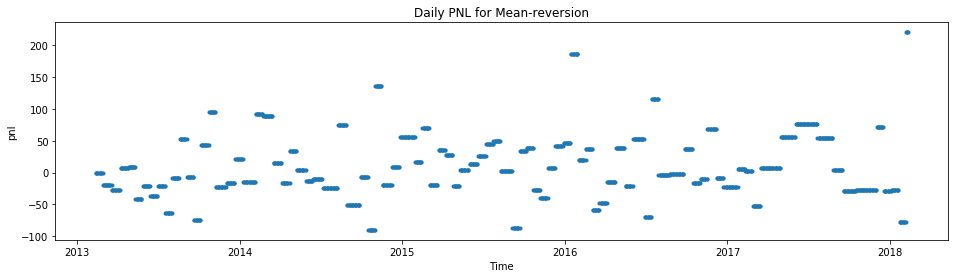

In [56]:
# plot PNL figures for mean-reversion
#daily
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("pnl")
plt.title("Daily PNL for Mean-reversion")
plt.show()

In [60]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.499801508535133


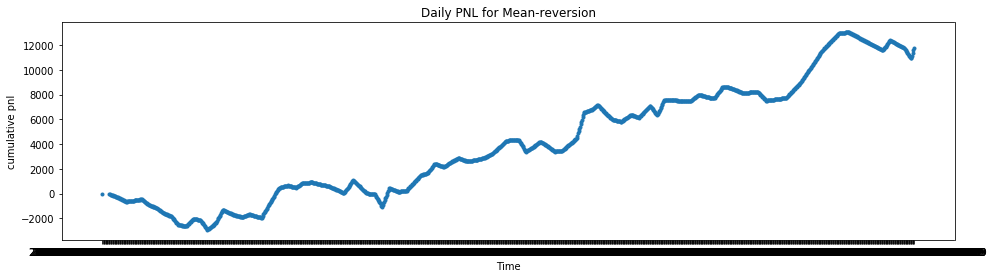

In [65]:
# plot PNL figures for mean-reversion
#daily
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['c_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL for Mean-reversion")
plt.show()